# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric, DatasetCorrelationsMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
files = [('green_tripdata_2024-03.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-01.parquet: 100%|██████████| 1254291/1254291 [00:10<00:00, 122076.87it/s, save to ./data/green_tripdata_2022-01.parquet]


In [3]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [4]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026354,2022-01-16 14:37:37.189551,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,2022-01-08 23:41:50,2022-01-08 23:55:28.500000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,2022-01-24 09:16:50,2022-01-24 09:37:28,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [5]:
jan_data.shape

(62495, 20)

In [6]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

<Axes: >

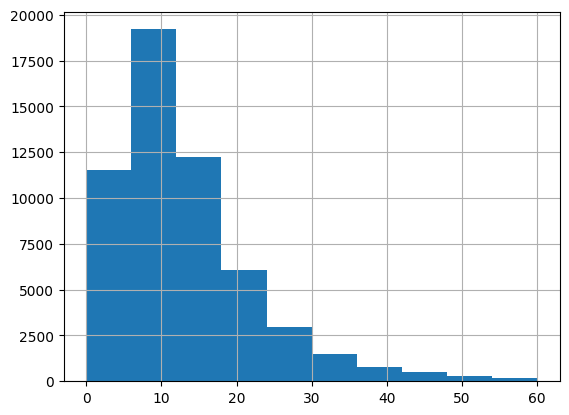

In [8]:
jan_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
jan_data.shape

(55211, 21)

In [11]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.804665373785062
4.142064073688447


# Dump model and reference data

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [19]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [20]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ColumnQuantileMetric(column_name='fare_amount', quantile=0.5), 
    DatasetCorrelationsMetric()
]
)

In [21]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [22]:
# report.show(mode='inline')

In [23]:
result = report.as_dict()

In [24]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.03049316466166379,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-36.73636669418381,
       -15.174383681788164,
       6.387599330607479,
       27.949582343003122,
       49.511565355398766,
       71.07354836779442,
       92.63553138019006,
       114.1975143925857,
       135.75949740498135,
       157.321480417377,
       178.88346342977263],
      'y': [9.197953980856964e-06,
       0.00110927325009135,
       0.04410786851980149,
       0.0010780002065564362,
       4.598976990428481e-05,
       1.6556317165542536e-05,
       1.8395907961713929e-06,
       3.6791815923427858e-06,
       1.8395907961713929e-06,
       3.6791815923427858e-06]}},
    'reference': {'small_distribution': {'x': [-28.669071967171647,
       -9.81048482283448

In [25]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.03049316466166379

In [26]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [27]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.045454545454545456

In [28]:
# column quantile
result['metrics'][3]['result']['current']['value']

10.0

# Evidently Dashboard

In [29]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [44]:
ws = Workspace("workspace")

In [45]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project descriotion"
project.save()

Project(id=UUID('da6d2877-bc36-4c22-87e4-aa9e68072879'), name='NYC Taxi Data Quality Project', description='My project descriotion', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 19, 23, 36, 50, 778505))

In [46]:
regular_report = Report(
    metrics=[
        DataQualityPreset(),
        ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
    ],
    timestamp=datetime.datetime(2022,1,28)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-28', '2022-01-29', inclusive="left")],
                  column_mapping=column_mapping)

# regular_report

/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()


In [47]:
ws.add_report(project.id, regular_report)

In [48]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Column Quantile Metric",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current.value",
                legend="quantile_0.5_value"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('da6d2877-bc36-4c22-87e4-aa9e68072879'), name='NYC Taxi Data Quality Project', description='My project descriotion', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('f4c47eb2-ef4c-4ac5-bc16-5362067aecb1'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('8b7e0887-0646-46bd-add6-35e80dfd9c0e'), title='Inference Count', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.number_of_rows', metric_id='DatasetSummaryMetric', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.BAR: 'bar'>), DashboardPanelPlot(

In [50]:
regular_report = Report(
    metrics=[
        DataQualityPreset(),
        ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)        
    ],
    timestamp=datetime.datetime(2022,1,29)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-29', '2022-01-30', inclusive="left")],
                  column_mapping=column_mapping)

# regular_report

/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()


In [51]:
ws.add_report(project.id, regular_report)

# Column Quantile

In [61]:
raw_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')
raw_data['prediction'] = model.predict(raw_data[num_features + cat_features].fillna(0))

In [72]:
project = ws.create_project("NYC Taxi Column Quantile Project")
project.description = "My project description"
project.save()

#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Column Quantile Metric",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current.value",
                legend="quantile_0.5_value"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('c3110e0d-d00a-4cd7-bbdd-1526f7d03e17'), name='NYC Taxi Column Quantile Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Column Quantile Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('fde3f016-3068-4520-adfc-2b426ac6242c'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('37f92e98-ddd2-4697-980e-9531fbe19140'), title='Column Quantile Metric', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.value', metric_id='ColumnQuantileMetric', metric_fingerprint=None, metric_args={}, legend='quantile_0.5_value')], plot_type=<PlotType.LINE: 'line'>)],

In [73]:
import datetime
begin = datetime.datetime(2024, 3, 1, 0, 0)
end = datetime.datetime(2024, 4, 1, 0, 0)

while begin < end:
    regular_report = Report(
        metrics=[
            DataQualityPreset(),
            ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
        ],
        timestamp=begin
    )
    
    regular_report.run(reference_data=None,
                       current_data=raw_data.loc[raw_data.lpep_pickup_datetime.between(begin, begin + datetime.timedelta(1), inclusive="left")],
                       column_mapping=column_mapping)
    
    ws.add_report(project.id, regular_report)
    
    begin = begin + datetime.timedelta(1)


/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/minasonbol/Documents/study/mlops-zoomcamp/mlops/lib/python3.10/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/minasonbol/Documents/s

# Grafana Daily Report

In [ ]:
import joblib
reference_data = pd.read_parquet('data/reference.parquet')
with open('models/lin_reg.bin', 'rb') as f_in:
	model = joblib.load(f_in)
    
raw_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [ ]:
import logging 
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s]: %(message)s")

In [ ]:
import random
SEND_TIMEOUT = 10
rand = random.Random()

In [ ]:
create_table_statement = """
drop table if exists dummy_metrics;
create table dummy_metrics(
	timestamp timestamp,
	prediction_drift float,
	num_drifted_columns integer,
	share_missing_values float,
	column_quantile float
)
"""

In [ ]:
import psycopg
def prep_db():
	with psycopg.connect("host=localhost port=5432 user=postgres password=example", autocommit=True) as conn:
		res = conn.execute("SELECT 1 FROM pg_database WHERE datname='test'")
		if len(res.fetchall()) == 0:
			conn.execute("create database test;")
		with psycopg.connect("host=localhost port=5432 dbname=test user=postgres password=example") as conn:
			conn.execute(create_table_statement)

In [ ]:
import datetime
import time
begin = datetime.datetime(2024, 3, 1, 0, 0)
def calculate_metrics_postgresql(curr, i):
	current_data = raw_data[(raw_data.lpep_pickup_datetime >= (begin + datetime.timedelta(i))) &
		(raw_data.lpep_pickup_datetime < (begin + datetime.timedelta(i + 1)))]

	#current_data.fillna(0, inplace=True)
	current_data['prediction'] = model.predict(current_data[num_features + cat_features].fillna(0))

	report.run(reference_data = reference_data, current_data = current_data,
		column_mapping=column_mapping)

	result = report.as_dict()

	prediction_drift = result['metrics'][0]['result']['drift_score']
	num_drifted_columns = result['metrics'][1]['result']['number_of_drifted_columns']
	share_missing_values = result['metrics'][2]['result']['current']['share_of_missing_values']
	column_quantile = result['metrics'][3]['result']['current']['value']

	curr.execute(
		"insert into dummy_metrics(timestamp, prediction_drift, num_drifted_columns, share_missing_values, column_quantile) values (%s, %s, %s, %s, %s)",
		(begin + datetime.timedelta(i), prediction_drift, num_drifted_columns, share_missing_values, column_quantile)
	)

In [ ]:
def batch_monitoring_backfill():
	prep_db()
	last_send = datetime.datetime.now() - datetime.timedelta(seconds=10)
	with psycopg.connect("host=localhost port=5432 dbname=test user=postgres password=example", autocommit=True) as conn:
		for i in range(0, 31):
			with conn.cursor() as curr:
				calculate_metrics_postgresql(curr, i)

			new_send = datetime.datetime.now()
			seconds_elapsed = (new_send - last_send).total_seconds()
			if seconds_elapsed < SEND_TIMEOUT:
				time.sleep(SEND_TIMEOUT - seconds_elapsed)
			while last_send < new_send:
				last_send = last_send + datetime.timedelta(seconds=10)
			logging.info("data sent")

In [ ]:
batch_monitoring_backfill()

KeyboardInterrupt: 